In [12]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from collections import Counter
from datetime import datetime, timedelta
from sklearn import metrics

%matplotlib inline                                
#no need to do plt.show()

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [13]:
train.describe()

,id,speed
count,14006.00000,14006.000000
mean,7002.50000,32.779118
std,4043.32827,13.573813
min,0.00000,2.573417
25%,3501.25000,19.301089
50%,7002.50000,36.580595
75%,10503.75000,45.877665
max,14005.00000,53.161286


In [14]:
train.isnull().sum()

id       0
date     0
speed    0
dtype: int64

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14006 entries, 0 to 14005
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      14006 non-null  int64  
 1   date    14006 non-null  object 
 2   speed   14006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 328.4+ KB


Text(0, 0.5, 'Frequency')

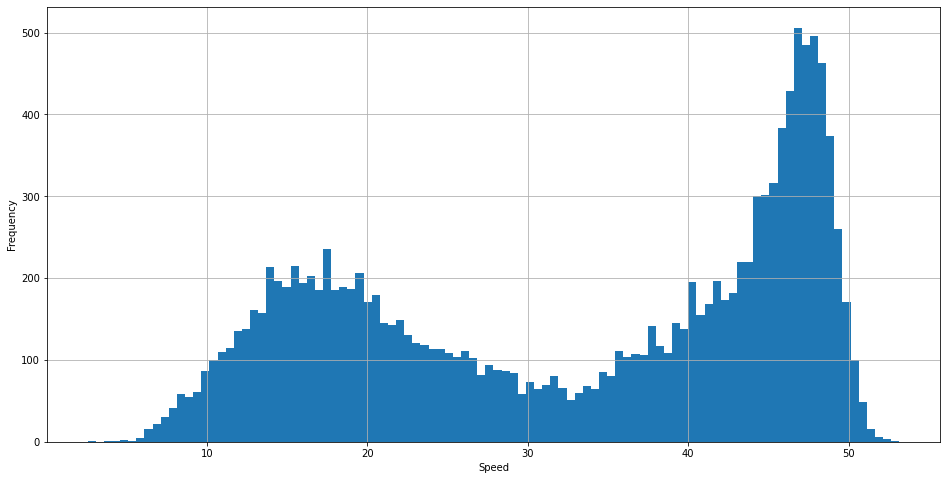

In [16]:
train.speed.hist(bins=100,figsize = (16,8))
plt.xlabel("Speed")
plt.ylabel("Frequency")

In [17]:
train = pd.read_csv('./train.csv',parse_dates=['date'])
test = pd.read_csv('./test.csv',parse_dates=['date'],index_col = 0)
print( ' train shape:{}, columns:{} '.format(train.shape,train.columns))
print( ' test shape:{}, columns:{}'.format(test.shape,test.columns))

print(train['date'].head())
print(train.columns)
train.info()

 train shape:(14006, 3), columns:Index(['id', 'date', 'speed'], dtype='object') 
 test shape:(3504, 1), columns:Index(['date'], dtype='object')
0   2017-01-01 00:00:00
1   2017-01-01 01:00:00
2   2017-01-01 02:00:00
3   2017-01-01 03:00:00
4   2017-01-01 04:00:00
Name: date, dtype: datetime64[ns]
Index(['id', 'date', 'speed'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14006 entries, 0 to 14005
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      14006 non-null  int64         
 1   date    14006 non-null  datetime64[ns]
 2   speed   14006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 328.4 KB


In [18]:
for df in (train,test):
    df['year']  = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day']   = df['date'].dt.day
    df['hr']    = df['date'].dt.hour
    df["weekday"] = df['date'].dt.weekday
    
for df in (train,test):
    df['hr_categori'] = np.nan #创建一个空字段，选择一个内容进行占位，不影响后面数据的插入
    df.loc[(df.weekday <= 4)&(df.weekday >= 0)&(df.hr <= 9)&(df.hr >= 8), 'hr_categori'] = "morningrush"   #工作日的早高峰8-9点
    df.loc[(df.weekday <= 4)&(df.weekday >= 0)&(df.hr <= 19)&(df.hr >= 17), 'hr_categori'] = "eveningrush" #工作日的晚高峰17-19点
    df.loc[(df.weekday <= 4)&(df.weekday >= 0)&(df.hr < 17)&(df.hr > 9), 'hr_categori'] = "day"
    df.loc[(df.weekday <= 4)&(df.weekday >= 0)&(df.hr < 8)|(df.hr > 19), 'hr_categori'] = "night"
    df.loc[(df.weekday >= 5)&(df.hr < 18)&(df.hr > 7), 'hr_categori'] = "day"                        #周末的白天
    df.loc[(df.weekday >= 5)&(df.hr <= 7)|(df.hr >= 18), 'hr_categori'] = "night"                    #周末的晚上

#######再加一个季节判断
season_dict = {
    1: 'spring', 2: 'spring', 3: 'spring',
    4: 'summer', 5: 'summer', 6: 'summer',
    7: 'fall', 8: 'fall', 9: 'fall',
    10: 'winter', 11: 'winter', 12: 'winter',}

for df in (train,test):
    df['season']=df['month'].map(season_dict)
    
####加载香港2017 2018节假日
public_vacation_list = [
    '20180101', '20180216','20180217','20180219','20180330','20180331','20180402','20180405',
    '20180501','20180522','20180618','20180702','20180925','20181001','20181017','20181225','20181226',
    '20170102','20170128','20170130','20170131','20170404','20170414','20170415','20170417','20170501',
    '20170503','20170530','20170701','20171002','20171005','20171028','20171225','20171226'
] 
for df in (train,test):
    df['only-ymd'] = df['date'].apply(lambda x: x.strftime('%Y%m%d'))
    df['y/n-holiday'] = df['only-ymd'].apply(lambda x: 1 if x in public_vacation_list else 0)
    
######加月中月初月末
for df in (train,test):
    df['monthinterval'] = np.nan #创建一个空字段，选择一个内容进行占位，不影响后面数据的插入
    df.loc[(df.day <= 10)&(df.day >= 1), 'monthinterval'] = "early"   #月初 [1-10]
    df.loc[(df.day <= 20)&(df.day > 10), 'monthinterval'] = "mid"   #月中 (10-20]
    df.loc[(df.day <= 31)&(df.day > 20), 'monthinterval'] = "end"   #月末 （20-31]
    

    
train.head(50)

,id,date,speed,year,month,day,hr,weekday,hr_categori,season,only-ymd,y/n-holiday,monthinterval
0,0,2017-01-01 00:00:00,43.002930,2017,1,1,0,6,night,spring,20170101,0,early
1,1,2017-01-01 01:00:00,46.118696,2017,1,1,1,6,night,spring,20170101,0,early
2,2,2017-01-01 02:00:00,44.294158,2017,1,1,2,6,night,spring,20170101,0,early
3,3,2017-01-01 03:00:00,41.067468,2017,1,1,3,6,night,spring,20170101,0,early
4,4,2017-01-01 04:00:00,46.448653,2017,1,1,4,6,night,spring,20170101,0,early
5,5,2017-01-01 05:00:00,46.797766,2017,1,1,5,6,night,spring,20170101,0,early
6,6,2017-01-01 06:00:00,44.404925,2017,1,1,6,6,night,spring,20170101,0,early
7,7,2017-01-01 07:00:00,45.255897,2017,1,1,7,6,night,spring,20170101,0,early
8,8,2017-01-01 08:00:00,45.680859,2017,1,1,8,6,day,spring,20170101,0,early
9,9,2017-01-01 09:00:00,48.435676,2017,1,1,9,6,day,spring,20170101,0,early


In [19]:
df_train = train.drop(columns= ['only-ymd','date'], axis= 1).copy()
df_test = test.drop(columns= ['only-ymd','date'], axis= 1).copy()

In [20]:
df_train.head()

,id,speed,year,month,day,hr,weekday,hr_categori,season,y/n-holiday,monthinterval
0,0,43.002930,2017,1,1,0,6,night,spring,0,early
1,1,46.118696,2017,1,1,1,6,night,spring,0,early
2,2,44.294158,2017,1,1,2,6,night,spring,0,early
3,3,41.067468,2017,1,1,3,6,night,spring,0,early
4,4,46.448653,2017,1,1,4,6,night,spring,0,early


In [21]:
### df_train  df_test

month_train = pd.get_dummies(df_train['month'], prefix='m', prefix_sep='_') 
month_test = pd.get_dummies(df_test['month'], prefix='m', prefix_sep='_')

hour_train = pd.get_dummies(df_train['hr'], prefix='h', prefix_sep='_')         #h-hr
hour_test = pd.get_dummies(df_test['hr'], prefix='h', prefix_sep='_')

hour_cate_train = pd.get_dummies(df_train['hr_categori'], prefix='hc', prefix_sep='_')    #这个也是分类数据
hour_cate_test = pd.get_dummies(df_test['hr_categori'], prefix='hc', prefix_sep='_')

dow_train = pd.get_dummies(df_train['weekday'], prefix='weekday', prefix_sep='_') #将确认为星期几也是属于分类的数据
dow_test = pd.get_dummies(df_test['weekday'], prefix='weekday', prefix_sep='_')

ss_train = pd.get_dummies(df_train['season'], prefix='ss', prefix_sep='_') #将确认为季节也是属于分类的数据
ss_test = pd.get_dummies(df_test['season'], prefix='ss', prefix_sep='_')

hour_cate_train.head()

,hc_day,hc_eveningrush,hc_morningrush,hc_night
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [22]:
#因为已经将属性标签（7个分类数据）进行独热编码处理了，那么原来的字段数据就可以进行删除了
#（这些数据有的会有大小之间的关系，造成不希望的结果），避免对模型预测产生影响
train = df_train.drop(['year','month','hr','weekday','hr_categori','season','id'],axis = 1)

test = df_test.drop(['year','month','hr','weekday','hr_categori','season'], axis = 1)

test['y_2017']=0

##加载编码过后的数据
Train_Master = pd.concat([train,
                          
                          ss_train,
                          dow_train,
                          hour_cate_train,
                          hour_train,
                          
                          month_train ], axis=1)

Test_master = pd.concat([test, 
                         
                         ss_test,
                         dow_test,
                         hour_cate_test,
                         hour_test,
                         
                         month_test ], axis=1)


In [24]:

X_train = Train_Master.drop(['speed'], axis=1)     #提取训练数据自变量

Y_train = Train_Master["speed"]                    #提取训练数据因变量


Y_train = Y_train.reset_index().drop('index',axis = 1)
#重新进行索引顺序

X_train.head()

,day,y/n-holiday,monthinterval,ss_fall,ss_spring,ss_summer,ss_winter,weekday_0,weekday_1,weekday_2,...,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
0,1,0,early,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,early,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,early,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,early,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,early,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn import ensemble
import sklearn.metrics

xgb1 = XGBRegressor()
# parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               #'objective':['reg:linear'],
#               'learning_rate': [0.001,.03, 0.05,.01,.1], #so called `eta` value
#               'max_depth': [5,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#               'min_child_weight': [1,2,3,4,5,6,7,8,9,10],
#               #'silent': [1],
#               'subsample': [0.6, 0.7, 0.8, 0.9],
#               'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
#               'n_estimators': [400,600,800,1000,2000,3000],
#               'gamma':[0.1,0.3,0.5,0.6],
#               'reg_alpha': [0.05, 0.1, 1, 2], 
#               'reg_lambda': [0.05, 0.1, 1, 2]}

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              #'objective':['reg:linear'],
              'learning_rate': [0.01], #so called `eta` value
              'max_depth': [10, None],
              'min_child_weight': [1],
              #'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.8],
              'n_estimators': [1500],
              'gamma':[0],
              'colsample_bylevel':[0.7],
              'reg_alpha': [1], 
              'reg_lambda': [1]}


clf = RandomizedSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True,scoring = "neg_mean_squared_error")
clf.fit(X_train,Y_train)
print(clf.best_estimator_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  1.7min finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=4, nthread=4, num_parallel_tree=1,
             random_state=0, reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
             subsample=0.7, tree_method='exact', validate_parameters=1,
             verbosity=None)


In [42]:
print(clf.best_score_)

-22.336630146938838


In [39]:
from sklearn.model_selection import train_test_split
#留出法划分数据,就按照经典的37分
Train, Test = train_test_split(Train_Master, test_size = 0.3)  

#注意这里的test是从编码过后的训练集Train_Master中挑出来的；拥有训练数据中所有的特征，用来检测模型是否过拟合或者满足要求！

X_train = Train.drop(['speed'], axis=1)     #提取训练数据自变量

Y_train = Train["speed"]                    #提取训练数据因变量

X_test = Test.drop(['speed'], axis=1)       #提取测试数据自变量

Y_test = Test["speed"]                      #提取测试数据因变量

Y_test = Y_test.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)
#重新进行索引顺序


#加载模型，放入相关数据
dtrain = xgb.DMatrix(X_train, label=Y_train)    #放入训练数据
dvalid = xgb.DMatrix(X_test, label=Y_test)      #放入测试拟合与否的数据

dtest = xgb.DMatrix(Test_master)                #放入最终的需要提交的检测数据
xgb_pars = {
    'objective':          'reg:linear',
    'learning_rate':      0.01,
    'max_depth':          10,  
    'subsample':          0.7,
    'colsample_bytree':   0.8,
    'colsample_bylevel':  0.7,
    'silent':             0,
    'reg_alpha':          1,
}
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
#设置观测对象
model = xgb.train(xgb_pars, dtrain, 3000, watchlist, early_stopping_rounds=5,
      maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)


[00:48:01] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[00:48:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:34.75092	valid-rmse:34.51000
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 5 rounds.
[1]	train-rmse:34.41799	valid-rmse:34.18024
[2]	train-rmse:34.08469	valid-rmse:33.84970
[3]	train-rmse:33.76080	valid-rmse:33.52850
[4]	train-rmse:33.43646	valid-rmse:33.20658
[5]	train-rmse:33.11290	valid-rmse:32.88641
[6]	train-rmse:32.79489	valid-rmse:32.57049
[7]	train-rmse:32.48870	valid-rmse:32.26688

[168]	train-rmse:8.15606	valid-rmse:8.47355
[169]	train-rmse:8.09977	valid-rmse:8.42217
[170]	train-rmse:8.04713	valid-rmse:8.37344
[171]	train-rmse:7.99458	valid-rmse:8.32531
[172]	train-rmse:7.94332	valid-rmse:8.27766
[173]	train-rmse:7.88845	valid-rmse:8.22738
[174]	train-rmse:7.83480	valid-rmse:8.17805
[175]	train-rmse:7.78536	valid-rmse:8.13197
[176]	train-rmse:7.73615	valid-rmse:8.08663
[177]	train-rmse:7.68429	valid-rmse:8.03981
[178]	train-rmse:7.63391	valid-rmse:7.99410
[179]	train-rmse:7.58630	valid-rmse:7.95097
[180]	train-rmse:7.53787	valid-rmse:7.90688
[181]	train-rmse:7.49048	valid-rmse:7.86344
[182]	train-rmse:7.44326	valid-rmse:7.82075
[183]	train-rmse:7.39859	valid-rmse:7.78012
[184]	train-rmse:7.35583	valid-rmse:7.74174
[185]	train-rmse:7.30783	valid-rmse:7.69969
[186]	train-rmse:7.26342	valid-rmse:7.66085
[187]	train-rmse:7.21884	valid-rmse:7.62106
[188]	train-rmse:7.17328	valid-rmse:7.57979
[189]	train-rmse:7.13023	valid-rmse:7.54137
[190]	train-rmse:7.08755	valid-r

[355]	train-rmse:4.07518	valid-rmse:5.14036
[356]	train-rmse:4.06644	valid-rmse:5.13641
[357]	train-rmse:4.05791	valid-rmse:5.13090
[358]	train-rmse:4.05113	valid-rmse:5.12796
[359]	train-rmse:4.04516	valid-rmse:5.12521
[360]	train-rmse:4.03830	valid-rmse:5.12141
[361]	train-rmse:4.03204	valid-rmse:5.11832
[362]	train-rmse:4.02503	valid-rmse:5.11561
[363]	train-rmse:4.01912	valid-rmse:5.11308
[364]	train-rmse:4.01391	valid-rmse:5.11092
[365]	train-rmse:4.00603	valid-rmse:5.10630
[366]	train-rmse:3.99859	valid-rmse:5.10177
[367]	train-rmse:3.99284	valid-rmse:5.09924
[368]	train-rmse:3.98916	valid-rmse:5.09771
[369]	train-rmse:3.98408	valid-rmse:5.09577
[370]	train-rmse:3.97716	valid-rmse:5.09211
[371]	train-rmse:3.97364	valid-rmse:5.09062
[372]	train-rmse:3.96968	valid-rmse:5.08881
[373]	train-rmse:3.96205	valid-rmse:5.08455
[374]	train-rmse:3.95714	valid-rmse:5.08189
[375]	train-rmse:3.95095	valid-rmse:5.07906
[376]	train-rmse:3.94422	valid-rmse:5.07476
[377]	train-rmse:3.94025	valid-r

[542]	train-rmse:3.41287	valid-rmse:4.87672
[543]	train-rmse:3.41056	valid-rmse:4.87622
[544]	train-rmse:3.40814	valid-rmse:4.87539
[545]	train-rmse:3.40472	valid-rmse:4.87366
[546]	train-rmse:3.40365	valid-rmse:4.87385
[547]	train-rmse:3.40165	valid-rmse:4.87258
[548]	train-rmse:3.39914	valid-rmse:4.87181
[549]	train-rmse:3.39595	valid-rmse:4.87026
[550]	train-rmse:3.39387	valid-rmse:4.87022
[551]	train-rmse:3.39267	valid-rmse:4.87006
[552]	train-rmse:3.39115	valid-rmse:4.86990
[553]	train-rmse:3.38869	valid-rmse:4.86944
[554]	train-rmse:3.38677	valid-rmse:4.86917
[555]	train-rmse:3.38399	valid-rmse:4.86818
[556]	train-rmse:3.38128	valid-rmse:4.86714
[557]	train-rmse:3.37871	valid-rmse:4.86602
[558]	train-rmse:3.37604	valid-rmse:4.86464
[559]	train-rmse:3.37413	valid-rmse:4.86434
[560]	train-rmse:3.37188	valid-rmse:4.86411
[561]	train-rmse:3.37076	valid-rmse:4.86440
[562]	train-rmse:3.36969	valid-rmse:4.86466
[563]	train-rmse:3.36695	valid-rmse:4.86336
[564]	train-rmse:3.36389	valid-r

[729]	train-rmse:3.03931	valid-rmse:4.77302
[730]	train-rmse:3.03716	valid-rmse:4.77258
[731]	train-rmse:3.03442	valid-rmse:4.77095
[732]	train-rmse:3.03320	valid-rmse:4.77078
[733]	train-rmse:3.03240	valid-rmse:4.77103
[734]	train-rmse:3.03010	valid-rmse:4.76984
[735]	train-rmse:3.02834	valid-rmse:4.76976
[736]	train-rmse:3.02633	valid-rmse:4.76943
[737]	train-rmse:3.02391	valid-rmse:4.76865
[738]	train-rmse:3.02219	valid-rmse:4.76815
[739]	train-rmse:3.02047	valid-rmse:4.76814
[740]	train-rmse:3.01878	valid-rmse:4.76769
[741]	train-rmse:3.01812	valid-rmse:4.76763
[742]	train-rmse:3.01666	valid-rmse:4.76763
[743]	train-rmse:3.01514	valid-rmse:4.76729
[744]	train-rmse:3.01421	valid-rmse:4.76754
[745]	train-rmse:3.01212	valid-rmse:4.76678
[746]	train-rmse:3.00948	valid-rmse:4.76502
[747]	train-rmse:3.00759	valid-rmse:4.76466
[748]	train-rmse:3.00676	valid-rmse:4.76468
[749]	train-rmse:3.00601	valid-rmse:4.76474
[750]	train-rmse:3.00452	valid-rmse:4.76438
[751]	train-rmse:3.00219	valid-r

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

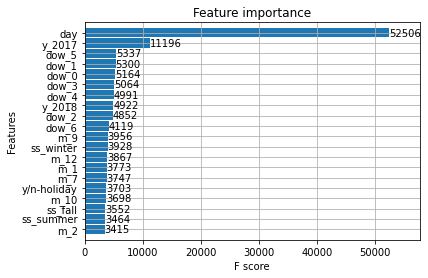

In [46]:
fscores = model.get_fscore()
#top_50_list = sorted(fscores, key=fscores.get, reverse=True)[:50]
#比如获得前50个特征的排序

xgb.plot_importance(model, max_num_features=20, height=0.9)
#前20特征值绘制条状图
